In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install torchvision

   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.2 MB 1.9 MB/s eta 0:00:04
   ------ --------------------------------- 1.0/6.2 MB 2.1 MB/s eta 0:00:03
   -------- ------------------------------- 1.3/6.2 MB 2.1 MB/s eta 0:00:03
   ----------- ---------------------------- 1.8/6.2 MB 1.8 MB/s eta 0:00:03
   --------------- ------------------------ 2.4/6.2 MB 2.0 MB/s eta 0:00:02
   -------------------- ------------------- 3.1/6.2 MB 2.2 MB/s eta 0:00:02
   ----------------------- ---------------- 3.7/6.2 MB 2.3 MB/s eta 0:00:02
   --------------------------- ------------ 4.2/6.2 MB 2.3 MB/s eta 0:00:01
   ------------------------------ --------- 4.7/6.2 MB 2.3 MB/s eta 0:00:01
   ----------------------------------- ---- 5.5/6.2 MB 2.4 MB/s eta 0:00:01
   -------------------------------------- - 6.0/6.2 MB 2.5 MB/s eta 0:00:01
   -----------------------

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # automatically divides by 255
])

In [16]:
import os
import shutil
import xml.etree.ElementTree as ET


In [21]:
classes = [
    "crazing",
    "inclusion",
    "patches",
    "pitted_surface",
    "rolled_in_scale",
    "scratches"
]



In [22]:
def create_class_folders(base_path, classes):
    for cls in classes:
        os.makedirs(os.path.join(base_path, cls), exist_ok=True)

train_out = "NEU-DET/train_cls"
val_out   = "NEU-DET/validation_cls"

create_class_folders(train_out, classes)
create_class_folders(val_out, classes)


In [23]:
def convert_split(annotation_dir, image_root, output_root):
    copied = 0
    missing = 0

    for xml_file in os.listdir(annotation_dir):
        if not xml_file.endswith(".xml"):
            continue

        xml_path = os.path.join(annotation_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find("filename").text.strip()

        # 🔑 Normalize class name (hyphen → underscore)
        raw_class = root.find("object").find("name").text.strip()
        class_name = raw_class.replace("-", "_")

        src_img = os.path.join(image_root, raw_class, filename)
        dst_img = os.path.join(output_root, class_name, filename)

        if os.path.exists(src_img):
            shutil.copy(src_img, dst_img)
            copied += 1
        else:
            print("Missing:", src_img)
            missing += 1

    print(f"Copied: {copied}, Missing: {missing}")


In [24]:
convert_split(
    annotation_dir="NEU-DET/train/annotations",
    image_root="NEU-DET/train/images",
    output_root="NEU-DET/train_cls"
)


Missing: NEU-DET/train/images\patches\patches_104
Missing: NEU-DET/train/images\patches\patches_106
Missing: NEU-DET/train/images\patches\patches_107
Missing: NEU-DET/train/images\patches\patches_12
Missing: NEU-DET/train/images\patches\patches_157
Missing: NEU-DET/train/images\patches\patches_158
Missing: NEU-DET/train/images\patches\patches_159
Missing: NEU-DET/train/images\patches\patches_160
Missing: NEU-DET/train/images\patches\patches_161
Missing: NEU-DET/train/images\patches\patches_162
Missing: NEU-DET/train/images\patches\patches_163
Missing: NEU-DET/train/images\patches\patches_164
Missing: NEU-DET/train/images\patches\patches_166
Missing: NEU-DET/train/images\patches\patches_169
Missing: NEU-DET/train/images\patches\patches_17
Missing: NEU-DET/train/images\patches\patches_170
Missing: NEU-DET/train/images\patches\patches_173
Missing: NEU-DET/train/images\patches\patches_177
Missing: NEU-DET/train/images\patches\patches_178
Missing: NEU-DET/train/images\patches\patches_18
Mis

In [25]:
convert_split(
    annotation_dir="NEU-DET/validation/annotations",
    image_root="NEU-DET/validation/images",
    output_root="NEU-DET/validation_cls"
)


Missing: NEU-DET/validation/images\crazing\crazing_240.jpg
Copied: 360, Missing: 1


In [26]:
print("TRAIN")
for cls in classes:
    print(cls, len(os.listdir(os.path.join("NEU-DET/train_cls", cls))))

print("\nVALIDATION")
for cls in classes:
    print(cls, len(os.listdir(os.path.join("NEU-DET/validation_cls", cls))))


TRAIN
crazing 239
inclusion 240
patches 194
pitted_surface 112
rolled_in_scale 240
scratches 240

VALIDATION
crazing 60
inclusion 60
patches 60
pitted_surface 60
rolled_in_scale 60
scratches 60


In [27]:
TRAIN_DIR = "NEU-DET/train_cls"
VAL_DIR   = "NEU-DET/validation_cls"

In [28]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [29]:
train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform
)

val_dataset = datasets.ImageFolder(
    root=VAL_DIR,
    transform=transform
)

In [30]:
print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled_in_scale', 'scratches']
Train samples: 1265
Validation samples: 360


In [31]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)

In [34]:
#making cnn
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,8,kernel_size=3,padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(8 * 112 * 112, 6)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
epochs = 5

for epoch in range(epochs):

    # ===== TRAIN =====
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

Epoch [1/5] | Train Loss: 6.1114 | Val Acc: 0.2639
Epoch [2/5] | Train Loss: 1.3944 | Val Acc: 0.5639
Epoch [3/5] | Train Loss: 1.0935 | Val Acc: 0.5222
Epoch [4/5] | Train Loss: 0.9051 | Val Acc: 0.5417
Epoch [5/5] | Train Loss: 0.8286 | Val Acc: 0.5306


In [37]:
#now we do data augmentation

In [38]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05)
    ),

    transforms.ToTensor()
])

In [39]:
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [40]:
train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=VAL_DIR,
    transform=val_transform
)

In [50]:
train_losses = []
val_accuracies = []

In [53]:
epochs = 10

for epoch in range(epochs):

    # ===== TRAIN =====
    model.train()
    train_loss = 0
    running_loss=0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)   

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

Epoch [1/10] | Train Loss: 0.1541 | Val Acc: 0.7917
Epoch [2/10] | Train Loss: 0.1639 | Val Acc: 0.7694
Epoch [3/10] | Train Loss: 0.1896 | Val Acc: 0.7528
Epoch [4/10] | Train Loss: 0.1602 | Val Acc: 0.7556
Epoch [5/10] | Train Loss: 0.1269 | Val Acc: 0.7722
Epoch [6/10] | Train Loss: 0.1272 | Val Acc: 0.7694
Epoch [7/10] | Train Loss: 0.1127 | Val Acc: 0.8111
Epoch [8/10] | Train Loss: 0.0896 | Val Acc: 0.8056
Epoch [9/10] | Train Loss: 0.0990 | Val Acc: 0.7333
Epoch [10/10] | Train Loss: 0.1651 | Val Acc: 0.6611


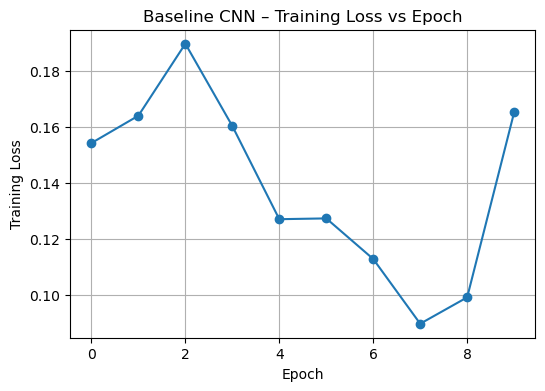

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Baseline CNN – Training Loss vs Epoch")
plt.grid(True)
plt.show()

In [42]:
#Confusion Matrix

In [43]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=100352, out_features=6, bias=True)
)

In [44]:
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [55]:
import torch

num_classes = len(train_dataset.classes)
cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1

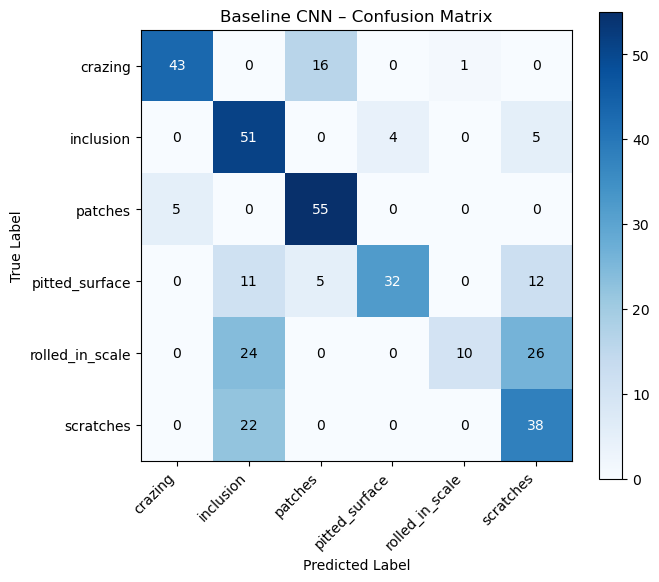

In [56]:
class_names = train_dataset.classes

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Baseline CNN – Confusion Matrix")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j].item(),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

In [57]:
per_class_acc = cm.diag() / cm.sum(dim=1)

print("\nPer-class accuracy:\n")
for cls, acc in zip(class_names, per_class_acc):
    print(f"{cls:20s}: {acc.item():.3f}")


Per-class accuracy:

crazing             : 0.717
inclusion           : 0.850
patches             : 0.917
pitted_surface      : 0.533
rolled_in_scale     : 0.167
scratches           : 0.633
